# COVID Early Warning System Project Overview

Project goals, tools and techniques used, and data source info can be found [here](https://github.com/salvir1/covid-early-warning-system)

In [1]:
import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import random
import warnings
from sklearn.cluster import KMeans
# from sklearn.metrics import silhouette_score
warnings.filterwarnings('ignore')

In [14]:
# Load in the COVID Tracking Project dataset by date and by state for US
covidtracking = pd.read_csv("https://api.covidtracking.com/v1/states/daily.csv")

df_state = covidtracking[['date', 'state', 'fips','positiveIncrease', 'deathIncrease', 'negativeIncrease']]
# df_state.info()

df_state['date'] = pd.to_datetime(df_state['date'], format='%Y%m%d')
df_state = df_state[df_state['date'] >= '2020-03-10']

st_population = pd.read_csv('../data/state_abbrev.csv', thousands=',') # Load in state population counts and merge with ctp data
df_state = df_state.merge(st_population, how='inner' ,left_on='state', right_on='Code')
# df_state.isna().sum() # No missing values!

In [15]:
# Create spring, summer, fall dataframes for Plotly scatterplot analysis
spr_deaths = df_state[(df_state['date'] >= '2020-04-01') & (df_state['date'] < '2020-07-01')]
smr_deaths = df_state[(df_state['date'] >= '2020-07-01') & (df_state['date'] < '2020-10-01')]
fall_deaths = df_state[(df_state['date'] >= '2020-10-01') & (df_state['date'] < '2021-01-01')]
spr_cases = df_state[(df_state['date'] >= '2020-03-10') & (df_state['date'] < '2020-06-10')]
smr_cases = df_state[(df_state['date'] >= '2020-06-10') & (df_state['date'] < '2020-09-10')]
fall_cases = df_state[(df_state['date'] >= '2020-09-10') & (df_state['date'] < '2020-12-10')]

spr_deaths = spr_deaths.groupby(['state', 'Population']).agg(
                                    deaths = ('deathIncrease', 'sum')
                                    ).reset_index()
smr_deaths = smr_deaths.groupby(['state', 'Population']).agg(
                                    deaths = ('deathIncrease', 'sum')
                                    ).reset_index()
fall_deaths = fall_deaths.groupby(['state', 'Population']).agg(
                                    deaths = ('deathIncrease', 'sum')
                                    ).reset_index()
spr_cases = spr_cases.groupby(['state', 'Population']).agg(
                                    cases = ('positiveIncrease','sum'),
                                    negatives = ('negativeIncrease','sum')
                                    ).reset_index()
smr_cases = smr_cases.groupby(['state', 'Population']).agg(
                                    cases = ('positiveIncrease','sum'),
                                    negatives = ('negativeIncrease','sum')
                                    ).reset_index()
fall_cases = fall_cases.groupby(['state', 'Population']).agg(
                                    cases = ('positiveIncrease','sum'),
                                    negatives = ('negativeIncrease','sum')
                                    ).reset_index()

spring = spr_deaths.merge(right=spr_cases,on=['state', 'Population'])
summer = smr_deaths.merge(right=smr_cases,on=['state', 'Population'])
fall = fall_deaths.merge(right=fall_cases,on=['state', 'Population'])

spring['death_rate'] = spring['deaths'] / spring['Population'] * 100000 / len(pd.date_range('2020-04-01','2020-07-01'))
summer['death_rate'] = summer['deaths'] / summer['Population'] * 100000 / len(pd.date_range('2020-07-01','2020-10-01'))
fall['death_rate'] = fall['deaths'] / fall['Population'] * 100000 / len(pd.date_range('2020-10-01', datetime.date.today()))

spring['case_rate'] = spring['cases']  / spring['Population'] * 100000 / len(pd.date_range('2020-03-10','2020-06-10'))
summer['case_rate'] = summer['cases']  / summer['Population'] * 100000 / len(pd.date_range('2020-06-10','2020-09-10'))
fall['case_rate'] = fall['cases']  / fall['Population'] * 100000 / len(pd.date_range('2020-09-10', datetime.date.today()))


In [16]:
# Use k means algorithm to create clusters of outbreak vs. no outbreak for the spring and summer timeframes based on death rate
km = KMeans(2)
spring['clusters'] = km.fit_predict(np.array(spring['death_rate']).reshape(-1,1)) - 1
summer['clusters'] = km.fit_predict(np.array(summer['death_rate']).reshape(-1,1)) - 1
fall['clusters'] = km.fit_predict(np.array(fall['case_rate']).reshape(-1,1)) - 1

In [17]:
spring_stats = spring.groupby('clusters').agg(case_averages = ('case_rate', 'mean'), death_averages = ('death_rate', 'mean'))
summer_stats = summer.groupby('clusters').agg(case_averages = ('case_rate', 'mean'), death_averages = ('death_rate', 'mean'))
fall_stats = fall.groupby('clusters').agg(case_averages = ('case_rate', 'mean'), death_averages = ('death_rate', 'mean'))

In [18]:
spring_stats, summer_stats, fall_stats

(          case_averages  death_averages
 clusters                               
 -1             4.524079        0.214297
  0            16.810611        1.238382,
           case_averages  death_averages
 clusters                               
 -1             9.339125        0.137279
  0            24.151472        0.494583,
           case_averages  death_averages
 clusters                               
 -1            51.618214        0.486433
  0            17.586431        0.227054)

In [7]:
fig = px.scatter(spring, 
                 x="death_rate", 
                 y='case_rate', 
                 labels = {'death_rate': 'Ave. daily deaths per 100,000 (4/1 - 7/1)',
                          'case_rate': 'Ave. daily cases per 100,000 (3/10 - 6/10)'},
                 size = 'death_rate',
                 color='clusters',
                 title = 'Severity of COVID During the Spring by State',
                 text='state')
fig.update_layout(
    font_color="black",
    font_size=15,
    title_font_size=25
)
fig.update(layout_coloraxis_showscale=False)
fig.write_image("img/spring-severity-scatter.png")
fig.write_html("img/spring-severity-scatter.html", auto_open=True)

In [8]:
fig = px.scatter(summer, 
                 x="death_rate", 
                 y='case_rate', 
                 labels = {'death_rate': 'Ave. daily deaths per 100,000 (7/1 - 10/1)',
                          'case_rate': 'Ave. daily cases per 100,000 (6/10 - 9/10)'},
                 size = 'death_rate',
                 color='clusters',
                 title = 'Severity of COVID During the Summer by State',
                 text='state')
fig.update_layout(
    font_color="black",
    font_size=15,
    title_font_size=25
)
fig.update(layout_coloraxis_showscale=False)
fig.write_image("img/summer-severity-scatter.png")
fig.write_html("img/summer-severity-scatter.html", auto_open=True)

In [9]:
fig = px.scatter(fall, 
                 x="death_rate", 
                 y='case_rate', 
                 labels = {'death_rate': 'Ave. daily deaths per 100,000 (10/1 - 12/31)',
                          'case_rate': 'Ave. daily cases per 100,000 (9/10 - 12/10)'},
                 size = 'death_rate',
                 color='clusters',
                 title = 'Severity of COVID During the Fall by State',
                 text='state')
fig.update_layout(
    font_color="black",
    font_size=15,
    title_font_size=25
)
fig.update(layout_coloraxis_showscale=False)
fig.write_image("img/fall-severity-scatter.png")   
fig.write_html("img/fall-severity-scatter.html", auto_open=True)   

### State-level case and death rate animations by week

In [19]:
df_state['CVD_group'] = df_state['CVD_group'].apply(lambda x: 'No outbreak' if x == 0 else x)
df_state['CVD_group'] = df_state['CVD_group'].apply(lambda x: 'Spring outbreak' if x == 1 else x)
df_state['CVD_group'] = df_state['CVD_group'].apply(lambda x: 'Summer outbreak' if x == 2 else x)
df_state['CVD_group'] = df_state['CVD_group'].apply(lambda x: 'Fall outbreak' if x == 3 else x)

In [20]:
# Prepare data table for the animation of deaths per 100,000 and cases per 100,000 by state.
# Group data by week for the animation, but convert it into a daily statistic for consistency with other charts

# Close out on a complete week (ending Sunday) when reporting weekly statistics.
today = datetime.date.today()
last_monday = pd.to_datetime(today + datetime.timedelta(days=-today.weekday(), weeks=0))
df_state = df_state[df_state['date'] < last_monday]
df_state = df_state.sort_values('date', ascending=True)

# Start by grouping by state and week. (Summing over the week speeds up the animation.)
df_state['week']=df_state['date'].dt.week
df_state_by_week = df_state.groupby(['week','state','Population']).agg(
                                    deaths = ('deathIncrease', 'sum'),
                                    cases = ('positiveIncrease','sum'),
                                    negatives = ('negativeIncrease','sum'),
                                    Date = ('date', 'max')).reset_index()

# Slight smoothing of death rate (2 weeks or 14 days total) to match the smoothing used in the groupings charts
death_SMA = []
for chart_state in df_state_by_week['state'].unique():
    state = df_state_by_week[df_state_by_week['state']== chart_state]
    death_SMA.append(state.iloc[:,3].rolling(window=2).mean())
df_state_by_week['death_SMA']= pd.concat(death_SMA)

# Calculate daily deaths per 100000.
df_state_by_week['deaths_per_100000'] = df_state_by_week['death_SMA'] / df_state_by_week['Population'] * 100000 / 7
df_state_by_week['cases_per_100000'] = df_state_by_week['cases'] / df_state_by_week['Population'] * 100000 / 7
df_state_by_week['positive_test_rate'] = df_state_by_week['cases'] / (df_state_by_week['cases'] + df_state_by_week['negatives'])

df_state_by_week['timestamp'] = df_state_by_week['Date'].apply(lambda x: x.date()).apply(str) # convert timestamp to a string 
df_state_by_week = df_state_by_week.sort_values('timestamp', ascending=True)

In [36]:
fig = px.choropleth(df_state_by_week,                   # Input Dataframe
                     locations="state",                 # state abbrev column
                     locationmode="USA-states",         # use plotly-supplied state geometries
                     color="cases_per_100000",          # feature column
                     hover_name="state",                # hover name
                     animation_frame="timestamp",       # date column
                     scope="usa",
                     color_continuous_scale = 'Viridis_r',  
                     range_color=[0,300/7],             # select range of dataset
                     labels={'cases_per_100000':'Cases per 100,000'},
                     title='Daily COVID cases per 100,000 residents'     
                     )                 
fig.write_html("img/case-rate-map.html", auto_open=True)                      

In [37]:
fig = px.choropleth(df_state_by_week,                   # Input Dataframe
                     locations="state",                 # state abbrev column
                     locationmode="USA-states",         # use plotly-supplied state geometries
                     color="positive_test_rate",        # feature column
                     hover_name="state",                # hover name
                     animation_frame="timestamp",       # date column
                     scope="usa",
                     color_continuous_scale = 'Viridis_r',  
                     range_color=[0,0.4],             # select range of dataset
                     labels={'positive_test_rate':'Positive test rate'},
                     title='COVID positive test rate'     
                     )                 
fig.write_html("img/positive-rate-map.html", auto_open=True)                      

In [38]:
fig = px.choropleth(df_state_by_week,                   # Input Dataframe
                     locations="state",                 # state abbrev column
                     locationmode="USA-states",         # use plotly-supplied state geometries
                     color="deaths_per_100000",         # feature column
                     hover_name="state",                # hover name
                     animation_frame="timestamp",       # date column
                     scope="usa",
                     color_continuous_scale = 'bluered',  
                     range_color=[0,5.5/7],             # select range of dataset
                     labels={'deaths_per_100000':'Deaths per 100,000'},
                     title='Daily COVID deaths per 100,000 residents'     
                     )        
fig.write_html("img/death-rate-map.html", auto_open=True)                      

### State level time series

In [21]:
# Calculate simple moving averages. 

case_SMA = []
death_SMA = []
negatives_SMA = []

for chart_state in df_state['state'].unique():
    state = df_state[df_state['state']== chart_state]
    df_state_by_week.sort_values('timestamp', ascending=True)
    case_SMA.append(state.iloc[:,3].rolling(window=14).mean())
    death_SMA.append(state.iloc[:,4].rolling(window=14).mean())
    negatives_SMA.append(state.iloc[:,5].rolling(window=14).mean())
df_state['case_SMA']= pd.concat(case_SMA)
df_state['death_SMA']= pd.concat(death_SMA)
df_state['negatives_SMA']= pd.concat(negatives_SMA)
df_state['positive_test_rate'] = df_state['case_SMA'] / (df_state['case_SMA'] + df_state['negatives_SMA'])
df_state['case_SMA'] = df_state['case_SMA'] / df_state['Population'] * 100000 # normalize by population
df_state['death_SMA'] = df_state['death_SMA'] / df_state['Population'] * 100000 # normalize by population

In [22]:
# Calculate the case_SMA change over 5, 10, 15 days to determine if rate of change correlates with groupings
case_SMA_5_day_change = []
case_SMA_10_day_change = []
case_SMA_15_day_change = []
for chart_state in df_state['state'].unique():
    state = df_state[df_state['state']== chart_state]
    case_SMA_5_day_change.append(state['case_SMA'] - state['case_SMA'].shift(5))
    case_SMA_10_day_change.append(state['case_SMA'] - state['case_SMA'].shift(10))
    case_SMA_15_day_change.append(state['case_SMA'] - state['case_SMA'].shift(15))
df_state['case_SMA_5_day_change']= pd.concat(case_SMA_5_day_change)
df_state['case_SMA_10_day_change']= pd.concat(case_SMA_10_day_change)
df_state['case_SMA_15_day_change']= pd.concat(case_SMA_15_day_change)


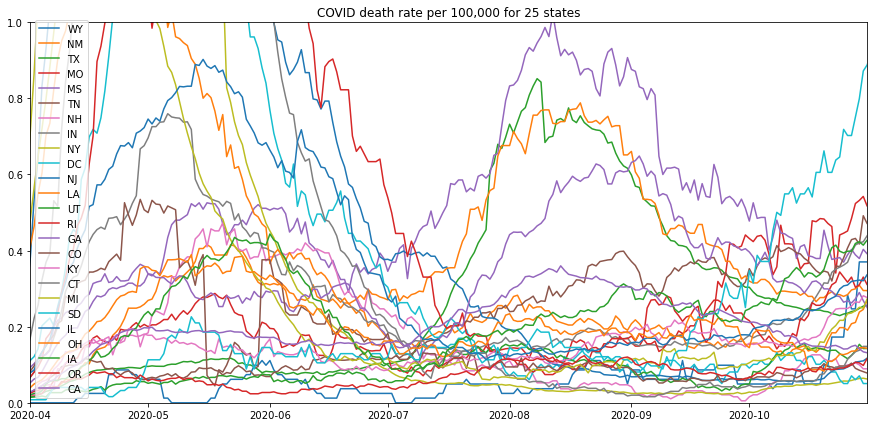

In [23]:
first, last = (0, 25)

# Death rate by state over time--ungrouped
fig, ax = plt.subplots(figsize = (15,7))
    
for chart_state in df_state['state'].unique()[first:last]:
    state_df = df_state[df_state['state']== chart_state]
#     state_df['case_SMA'] = state_df.iloc[:,3].rolling(window=14).mean()
#     state_df['death_SMA'] = state_df.iloc[:,4].rolling(window=14).mean()
#     temp_state_df = state_df[['date', 'death_SMA']]
#     temp_state_df['date'] = temp_state_df['date'] - timedelta(days=14)
#     state_df = state_df.merge(temp_state_df, on='date')
    ax.plot(state_df['date'], state_df['death_SMA'], label = chart_state)
    ax.set_xlim([datetime.date(2020, 4, 1), datetime.date(2020, 10, 31)])
    ax.set_ylim(0, 1)
    ax.set_title(f'COVID death rate per 100,000 for 25 states')
    ax.legend()
plt.savefig('img/COVID-deaths-by-state-large-group.png')

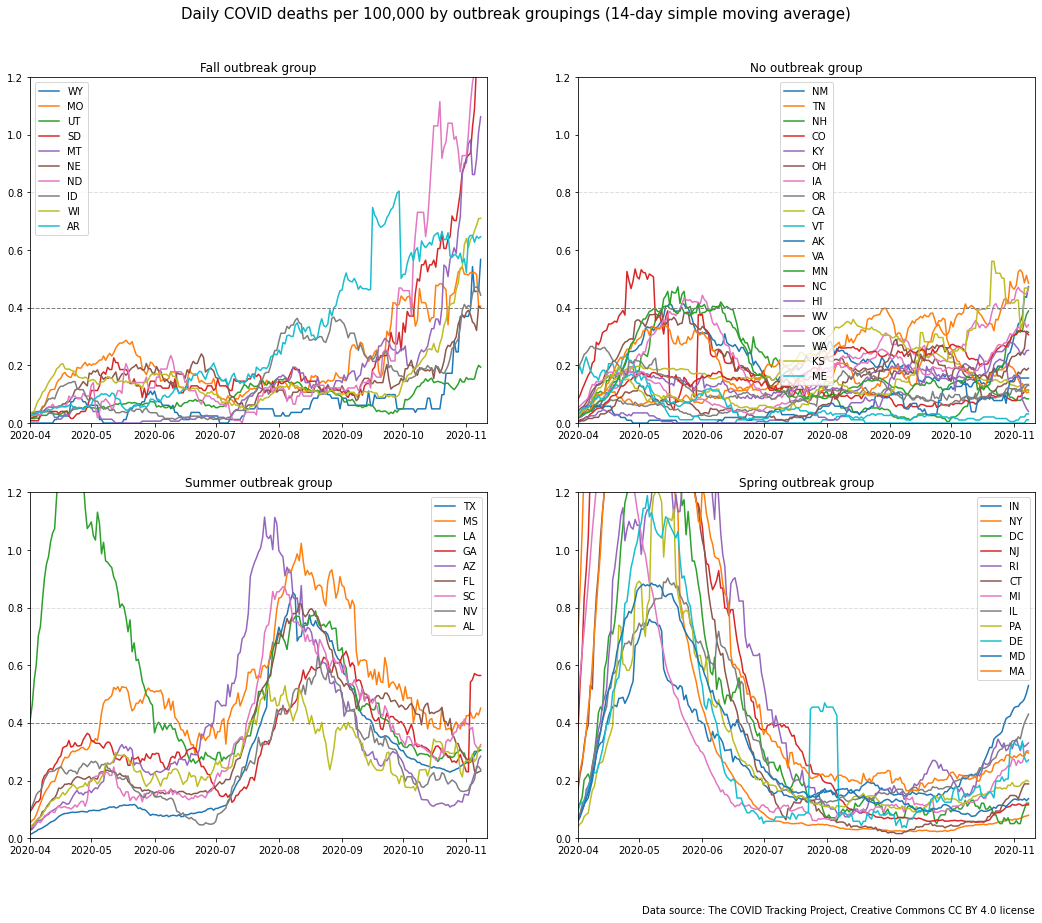

In [24]:
# Deaths per 100,000 by state over time
fig, ax = plt.subplots(2,2, figsize = (18,14))
plt.figtext(0.9, 0.05, 'Data source: The COVID Tracking Project, Creative Commons CC BY 4.0 license', horizontalalignment='right')
plt.suptitle(f'Daily COVID deaths per 100,000 by outbreak groupings (14-day simple moving average)', size=15, y=0.95)

i=0
for group in df_state['CVD_group'].unique():
    temp_df = df_state[df_state['CVD_group']==group]
    for chart_state in temp_df['state'].unique():
        state_df = temp_df[temp_df['state']== chart_state]
        ax[i//2][i%2].plot(state_df['date'], state_df['death_SMA'], label = chart_state)
    ax[i//2][i%2].axhline(y=0.8, ls= '--', lw=1, color = 'gray', alpha=0.25)
    ax[i//2][i%2].axhline(y=0.4, ls= '--', lw=1, color = 'gray')
    ax[i//2][i%2].set_xlim([datetime.date(2020, 4, 1), datetime.date.today()])
    ax[i//2][i%2].set_ylim([0,1.2])
    ax[i//2][i%2].set_title(f'{group} group')
    ax[i//2][i%2].legend()
    i += 1
plt.savefig('img/COVID-deaths-by-state.png')

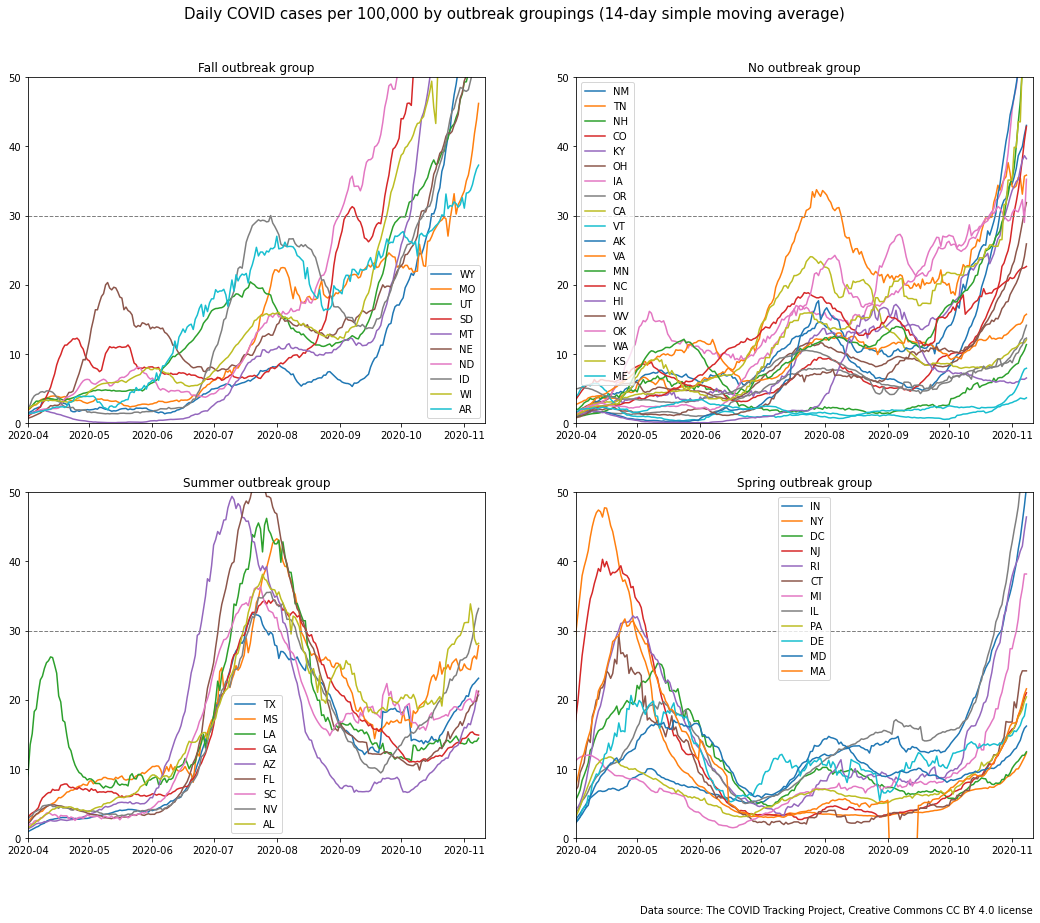

In [25]:
# Cases per 100,000 by state over time
fig, ax = plt.subplots(2,2, figsize = (18,14))
plt.figtext(0.9, 0.05, 'Data source: The COVID Tracking Project, Creative Commons CC BY 4.0 license', horizontalalignment='right')
plt.suptitle(f'Daily COVID cases per 100,000 by outbreak groupings (14-day simple moving average)', size=15, y=0.95)

i=0
for group in df_state['CVD_group'].unique():
    temp_df = df_state[df_state['CVD_group']==group]
    for chart_state in temp_df['state'].unique():
        state_df = temp_df[temp_df['state']== chart_state]
        ax[i//2][i%2].plot(state_df['date'], state_df['case_SMA'], label = chart_state)
    ax[i//2][i%2].axhline(y=30, ls= '--', lw=1, color = 'gray')
    ax[i//2][i%2].set_xlim([datetime.date(2020, 4, 1), datetime.date.today()])
    ax[i//2][i%2].set_ylim([0,50])
    ax[i//2][i%2].set_title(f'{group} group')
    ax[i//2][i%2].legend()
    i += 1
plt.savefig('img/COVID-cases-by-state.png')

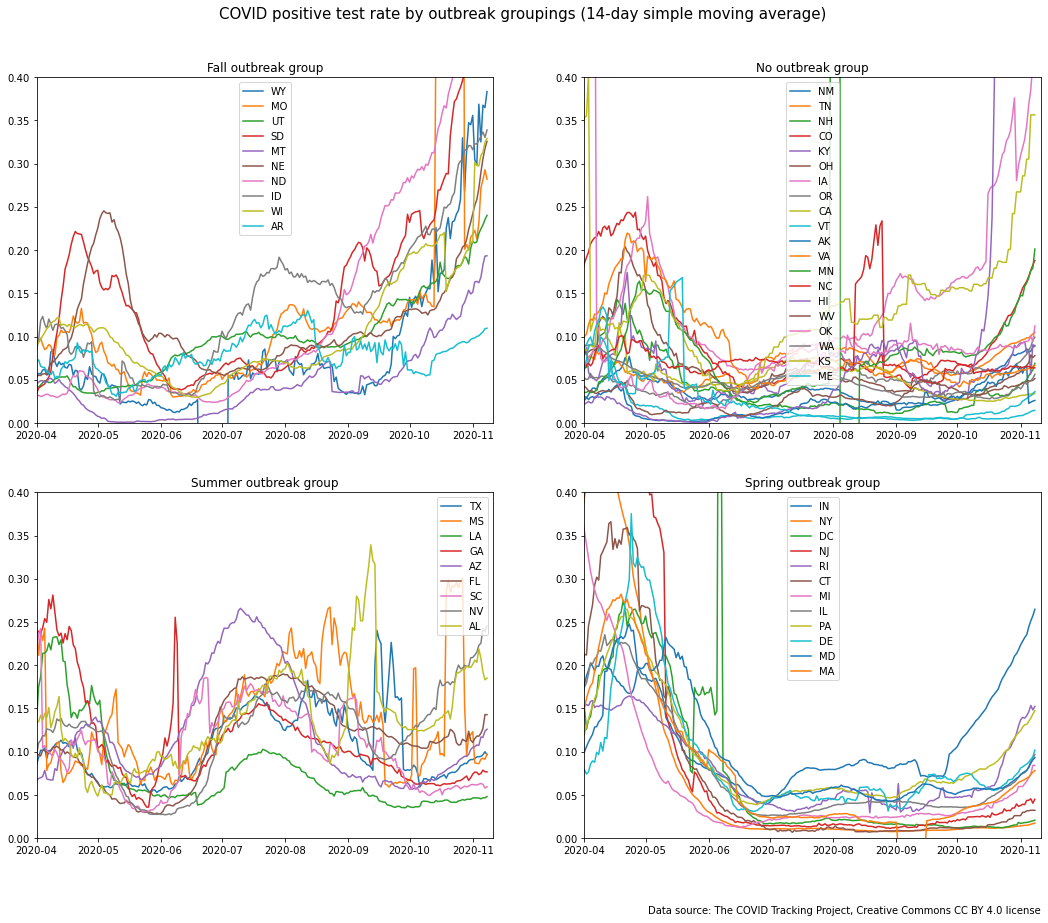

In [26]:
# Positive test rate by state over time
fig, ax = plt.subplots(2,2, figsize = (18,14))
plt.figtext(0.9, 0.05, 'Data source: The COVID Tracking Project, Creative Commons CC BY 4.0 license', horizontalalignment='right')
plt.suptitle(f'COVID positive test rate by outbreak groupings (14-day simple moving average)', size=15, y=0.95)

i=0
for group in df_state['CVD_group'].unique():
    temp_df = df_state[df_state['CVD_group']==group]
    for chart_state in temp_df['state'].unique():
        state_df = temp_df[temp_df['state']== chart_state]
        ax[i//2][i%2].plot(state_df['date'], state_df['positive_test_rate'], label = chart_state)
    ax[i//2][i%2].axhline(y=20, ls= '--', lw=1, color = 'gray')
    ax[i//2][i%2].set_xlim([datetime.date(2020, 4, 1), datetime.date.today()])
    ax[i//2][i%2].set_ylim([0,0.4])
    ax[i//2][i%2].set_title(f'{group} group')
    ax[i//2][i%2].legend()
    i += 1
plt.savefig('img/COVID-positive-test-rate-by-state.png')

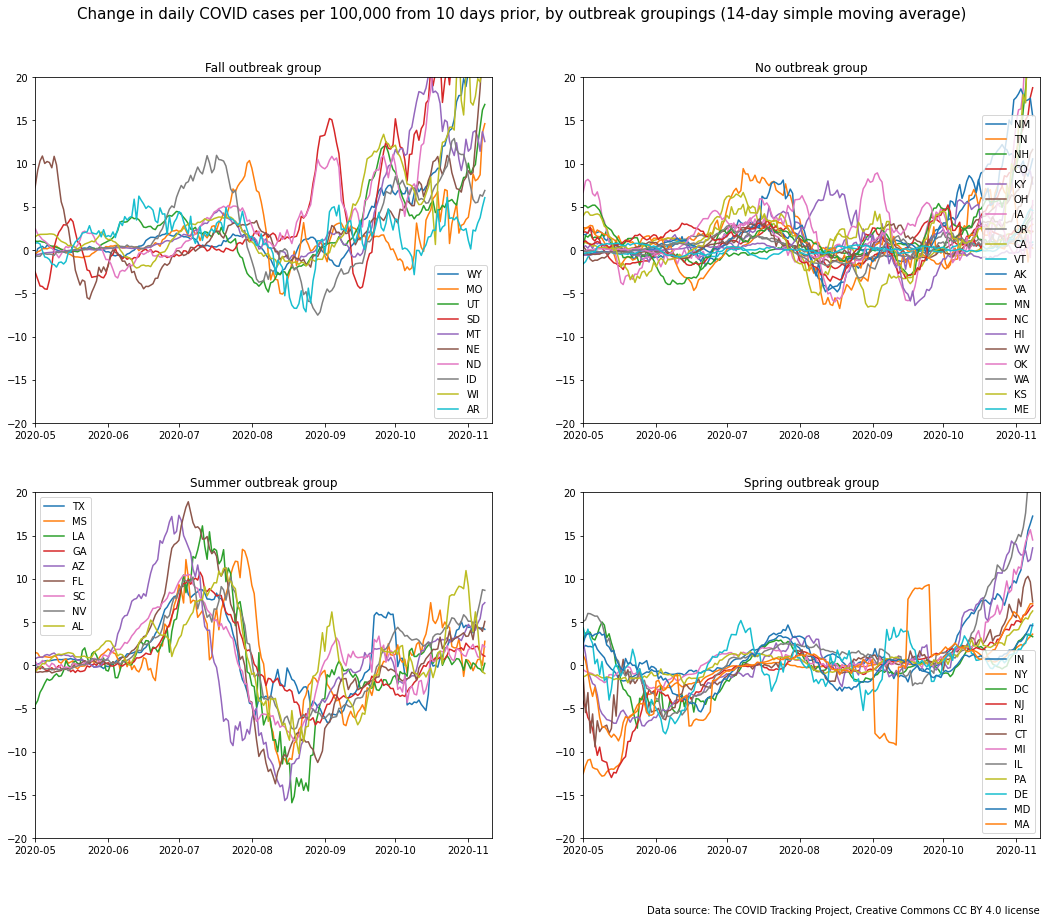

In [27]:
# Case rate change by state over time
fig, ax = plt.subplots(2,2, figsize = (18,14))
plt.figtext(0.9, 0.05, 'Data source: The COVID Tracking Project, Creative Commons CC BY 4.0 license', horizontalalignment='right')
plt.suptitle(f'Change in daily COVID cases per 100,000 from 10 days prior, by outbreak groupings (14-day simple moving average)', size=15, y=0.95)

i=0
for group in df_state['CVD_group'].unique():
    temp_df = df_state[df_state['CVD_group']==group]
    for chart_state in temp_df['state'].unique():
        state_df = temp_df[temp_df['state']== chart_state]
        ax[i//2][i%2].plot(state_df['date'], state_df['case_SMA_10_day_change'], label = chart_state)
#     ax[i//2][i%2].axhline(y=20, ls= '--', lw=1, color = 'gray')
    ax[i//2][i%2].set_xlim([datetime.date(2020, 5, 1), datetime.date.today()])
    ax[i//2][i%2].set_ylim([-20,20])
    ax[i//2][i%2].set_title(f'{group} group')
    ax[i//2][i%2].legend()
    i += 1

### Misc charts

In [22]:
chart_state = 'WA'
state_df = df_state[df_state['state']== chart_state]
state_df['case_SMA'] = state_df.iloc[:,3].rolling(window=14).mean()
state_df['death_SMA'] = state_df.iloc[:,4].rolling(window=14).mean()
temp_state_df = state_df[['date', 'death_SMA']]
temp_state_df['date'] = temp_state_df['date'] - timedelta(days=21)
state_df = state_df.merge(temp_state_df, on='date')

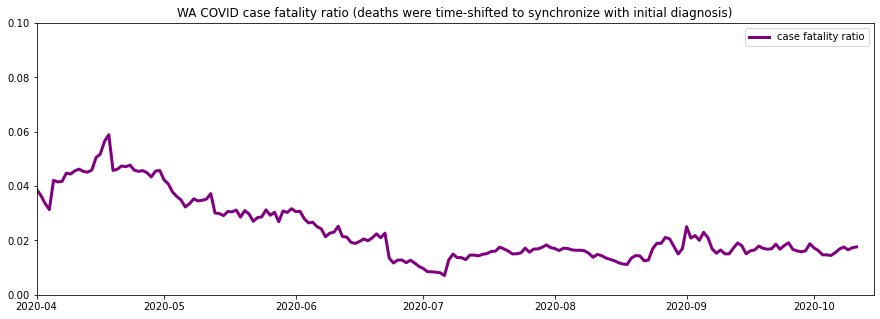

In [23]:
fig, ax = plt.subplots(figsize = (15,5))
ax.plot(state_df['date'], state_df['death_SMA_y'] / state_df['case_SMA'], label = 'case fatality ratio', color = 'purple', lw=3)
ax.set_xlim([datetime.date(2020, 4, 1), datetime.date(2020, 10, 15)])
ax.set_ylim(0, 0.1)
ax.set_title(f'{chart_state} COVID case fatality ratio (deaths were time-shifted to synchronize with initial diagnosis)')
ax.legend()

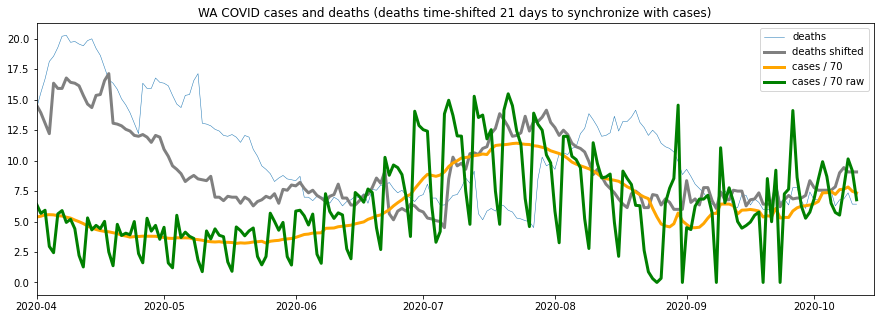

In [24]:
fig, ax = plt.subplots(figsize = (15,5))
ax.plot(state_df['date'], state_df['death_SMA_x'], label = 'deaths', lw= .5)
ax.plot(state_df['date'], state_df['death_SMA_y'], label = 'deaths shifted', color = 'gray', lw=3)
ax.plot(state_df['date'], state_df['case_SMA'] / 70, label = 'cases / 70', color = 'orange', lw=3)
ax.plot(state_df['date'], state_df['positiveIncrease'] / 70, label = 'cases / 70 raw', color = 'green', lw=3)
ax.set_xlim([datetime.date(2020, 4, 1), datetime.date(2020, 10, 15)])
ax.set_title(f'{chart_state} COVID cases and deaths (deaths time-shifted 21 days to synchronize with cases)')
ax.legend()

In [ ]:
# Case fatality ratio by state over time
fig, ax = plt.subplots(figsize = (15,7))
    
for chart_state in df_state['state'].unique()[first:last]:
    state_df = df_state[df_state['state']== chart_state]
    state_df['case_SMA'] = state_df.iloc[:,3].rolling(window=7).mean()
    state_df['death_SMA'] = state_df.iloc[:,4].rolling(window=7).mean()
    temp_state_df = state_df[['date', 'death_SMA']]
    temp_state_df['date'] = temp_state_df['date'] - timedelta(days=14)
    state_df = state_df.merge(temp_state_df, on='date')
    ax.plot(state_df['date'], state_df['death_SMA_y'] / state_df['case_SMA'], label = chart_state)
    ax.set_xlim([datetime.date(2020, 4, 1), datetime.date(2020, 10, 31)])
    ax.set_ylim(0, 0.1)
    ax.set_title(f'COVID case fatality ratio (deaths were time-shifted to synchronize with initial diagnosis)')
    ax.legend()

#### Issues with using positive test rate as a predictor

- Very noisy signal--Seattle Times reports it using a 28 day moving average (as compared to 14 days for cases and deaths)
- Why? 
- Test sites might have inherent differences in the types of people being tested. Clinics may be doing pre-procedural testing to confirm patients don't have COVID. Positive test rates from these sites will approximate disease prevalence among asymptomatic people, which is a very low number. Many of these clinics perform these tests only a few days a week.
- Locations run by public health agencies may be testing mostly symptomatic people on some of the days when they're open. Positive test rates from these sites on these days may exceed 25% or more.
- At different days for these same public health agency locations, they may test a high percentage of asymptomatic students from a school or employees from a company, thus reducing the positive test rate significantly.
- Different types of test methods have different false positive/false negative rates. If the balance of tests shifts (which is what we are seeing right now with more antigen detection rapid tests), this is going to result in differences in positive test rates.
- The number of tests from these different locations from different days will vary dramatically. Results from these tests get pooled together for reporting purposes, thus causing the positive test rate number to fluctuate for reasons that have nothing to do with changes in the actual infection rate.